<p align="center"><img alt="udeA logo" height="150px" src="https://github.com/freddyduitama/images/blob/master/logo.png?raw=true"></p><h1><font color='0B5345'> <center>

 </center></font></h1>
<h2><font color='0B5345'> <center>
Bioseñales y Sistemas</center></font></h2>
<font  face="Courier New" size="3">

 </center></font></h1>
<h2><font color='0B5345'> <center>
Proyecto 4: Clasificación de señales ECG </center></font></h2>
<font  face="Courier New" size="2">

 </center></font></h1>
<h2><font color='0B5345'> <center>
Isabella Vásquez García </center></font></h2>
<font  face="Courier New" size="1">

 </center></font></h1>
<h2><font color='0B5345'> <center>
C.C. 1000.438.341 </center></font></h2>
<font  face="Courier New" size="1">

 </center></font></h1>
<h2><font color='0B5345'> <center>
Marie Anne Johanna Bernal Diaz </center></font></h2>
<font  face="Courier New" size="1">

 </center></font></h1>
<h2><font color='0B5345'> <center>
C.C. 1003.894.043 </center></font></h2>
<font  face="Courier New" size="1">

<p3><center><b><font color='0B5345' face="Lucida Calligraphy,Comic Sans MS,Lucida Console" size="5">Universidad de Antioquia - Bioingeniería</font></b> </center></p3>

In [1]:
pip install neurokit2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.signal as signal
from scipy import fft
import scipy.io as sio;
import seaborn as sns
from scipy.signal import detrend
from scipy import stats
import neurokit2 as nk

# **1.Revisión Teórica**

Para acceder a las consultas de este proyecto (puntos 1, 8 y 9), ingresar al siguiente link:

[Consultas Proyecto 4](https://docs.google.com/document/d/12nTGzbK5JAjV9nh_iTNFU-E_y7MoYrLhJz70U5tDvMk/edit?usp=sharing)

# **2. Extracción de los archivos (Base de datos elegida)**

**La base de datos elegida fué la del proyecto 2**, es decir, los archivos ya procesados, dado que, según lo que se comenta en la página donde se extrajeron los datos (figshare), "El conjunto de datos se puede aplicar ampliamente para la investigación de algoritmos de inteligencia artificial o aprendizaje automático" [1].

Según lo anterior, inicialmente, se carga el archivo Diagnostics.xlsx con el fin de identificar los archivos pertenecientes a los pacientes con  bradicardia sinusal (**SB** Sinus Bradycardia) y fibrilación auricular (**AFIB** Atrial Fibrillation).

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
archivo_excel = 'Diagnostics.xlsx"'
df = pd.read_excel("/content/drive/MyDrive/Bioseñales/Diagnostics.xlsx")
df

,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
2,MUSE_20180111_165520_97000,SA,NONE,20,FEMALE,67,67,82,382,403,88,20,11,224,265,415
3,MUSE_20180113_121940_44000,SB,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447
4,MUSE_20180112_122850_57000,AF,STDD STTC,73,FEMALE,162,162,114,252,413,68,-40,26,228,285,354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10641,MUSE_20181222_204306_99000,SVT,NONE,80,FEMALE,196,73,168,284,513,258,244,32,177,261,319
10642,MUSE_20181222_204309_22000,SVT,NONE,81,FEMALE,162,81,162,294,482,110,-75,27,173,254,320
10643,MUSE_20181222_204310_31000,SVT,NONE,39,MALE,152,92,152,340,540,250,38,25,208,284,378
10644,MUSE_20181222_204312_58000,SVT,NONE,76,MALE,175,178,128,310,529,98,-83,29,205,269,360


Dado que se conocen los nombres de los archivos que representan las arritmias SB y AFIB, se obtiene una lista con los nombres
de cada archivo para cada arritmia y se imprime su longitud, con el fin de conocer cuántos archivos deberá tener la lista final.

In [5]:
df_SB = df[df["Rhythm"]=="SB"]
df_SB_file_names = df_SB["FileName"]
lista_SB_file_name = df_SB_file_names.tolist()
print(f"Cantidad de archivos para SB (bradicardia sinusal): {len(lista_SB_file_name)}")

df_AFIB = df[df["Rhythm"]=="AFIB"]
df_AFIB_file_names = df_AFIB["FileName"]
lista_AFIB_file_name = df_AFIB_file_names.tolist()
print(f"Cantidad de archivos para AFIB (fibrilación auricula): {len(lista_AFIB_file_name)}")

Cantidad de archivos para SB (bradicardia sinusal): 3889
Cantidad de archivos para AFIB (fibrilación auricula): 1780


Ahora, se recorre la carpeta de archivos en la carpeta ECGDataDenoised (ya descomprimida) que coincidan en nombre con los nombres de los archivos en cada una de las listas mencionadas anteriormente. Posteriormente, se verifica que la lista de archivos tenga el mismo número de elementos que la lista con los nombres.

In [6]:
carpeta_data = os.listdir('/content/drive/MyDrive/Bioseñales/ECGDataDenoised')
lista_SB = []
for archivo in carpeta_data:
    for nombre in lista_SB_file_name:
        if archivo in f"{nombre}.csv":
            lista_SB.append(archivo)


print(len(lista_SB))

3889


In [7]:
lista_AFIB = []
for archivo in carpeta_data:
    for nombre in lista_AFIB_file_name:
        if archivo in f"{nombre}.csv":
            lista_AFIB.append(archivo)

print(len(lista_AFIB))

1780


Ahora, se pocede a extraer los datos pertenecientes a la segunda derivación de cada archivo (tanto para SB como para AFIB).

In [8]:
def obtener_II_derivacion(ruta_carpeta, nombre_archivo, columnas):
    ruta = os.path.join(ruta_carpeta, nombre_archivo)
    try:
        data_frame = pd.read_csv(ruta, delimiter=',', names=columnas)
        signal = data_frame["II"]
    except FileNotFoundError:
        print(f'El archivo {archivo} no se encontró en {ruta_carpeta}.')
    return signal

In [9]:
names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ruta_carpeta = '/content/drive/MyDrive/Bioseñales/ECGDataDenoised'
list_SB_II = []
for archivo in lista_SB:
    signal = obtener_II_derivacion(ruta_carpeta, archivo, names)
    data = {"Nombre Archivo": archivo, "II": signal}
    list_SB_II.append(data)

df_SB = pd.DataFrame(list_SB_II)

In [10]:
names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ruta_carpeta = '/content/drive/MyDrive/Bioseñales/ECGDataDenoised'
list_AFIB_II = []

for archivo in lista_AFIB:
    signal = obtener_II_derivacion(ruta_carpeta, archivo, names)
    data = {"Nombre Archivo": archivo, "II": signal}
    list_AFIB_II.append(data)

df_AFIB = pd.DataFrame(list_AFIB_II)

#**3. Tutorial Neurokit2**

Para acceder al tutorial, hacer click en el siguiente enlace:

[Tutorial Neurokit2](https://colab.research.google.com/drive/1bdTjPoUT36HKYS-8ucRzM7uOke8syqZ1?usp=sharing)

# **4. Aplicación del tutorial**

Para esta sección, se aplicó el tutorial a todas las señales de cada grupo. Sin embargo, tal como se indica en el artículo del punto 1 "Optimal Multi-Stage Arrhythmia Classification Approach", **es necesario inicialmente normalizar las señales**. Según lo anterior, **se utilizó la función de compresión implementada en el proyecto 2** que permite obtener señales con una amplitud pico de 1.

Así mismo, el tutorial incluye una sección del procesamiento de las señales pero dado que las señales de la base de datos denoised ya cuenta con un procesamineto, del tutorial solo se utilizaran las secciones de extracción de características.

In [11]:
# Función para normalizar
def compression(serie):
    xmin = serie.min()
    xmax = serie.max()
    num = serie-xmin
    den = xmax - xmin
    compr = num/den
    return compr

In [12]:
# Función para extraer las características del tutorial
def extraccion_caracteristicas(signal, fs):
  signal_compress = compression(signal)
  # Identificación de los picos de la señal
  signals_peaks, rpeaks= nk.ecg_peaks(signal_compress, sampling_rate=fs, correct_artifacts=False)
  # Variación de la frecuencia cardíaca
  hrv = nk.hrv_time(rpeaks, sampling_rate=fs, show=False)
  # Características asociadas a la variación de la frecuencia cardiaca y al intervalo RR
  MeanNN = hrv["HRV_MeanNN"].values[0] # La media de los intervalos RR.
  SDNN = hrv["HRV_SDNN"].values[0] # Desviación estándar de los intervalos RR.
  RMSSD = hrv["HRV_RMSSD"].values[0] # Raíz cuadrada de la media de las diferencias sucesivas al cuadrado entre intervalos RR adyacentes
  pNN50 = hrv["HRV_pNN50"].values[0] # Porcentaje de diferencias absolutas en intervalos RR sucesivos mayores de 50 ms
  # Entropía de Shannon
  shanen, info = nk.entropy_shannon(signal_compress, symbolize=3, show=False)
  # Frecuencia cardiaca media
  heart_rate = nk.ecg_rate(rpeaks, sampling_rate=fs, desired_length=None, interpolation_method='monotone_cubic', show=False)
  # Se extrae el promedio de la frecuencia cardiaca
  heart_rate_average= np.mean(heart_rate)
  return MeanNN, SDNN, RMSSD, pNN50, shanen, heart_rate_average

#**5. Conjunto de características**

**Características extraídas de Neurokit2**

1. **SDNN: Desviación estándar de los intervalos RR**

2. **pNN50: Porcentaje de diferencias absolutas en intervalos RR sucesivos mayores de 50 ms**

Estas primeras dos características fueron utilizadas en un estudio donde evaluaron las mismas respecto a la mortalidad de personas con Arritmias como la fibrilación auricular (AFIB) [3]. Estas características están asociadas a métricas extraídas de los intervalos RR y están asociados a la onda R, la cual  es la característica más prominente dentro del ECG, lo que la hace relativamente sencilla de detectar [5]. Así mismo, el estudio de los intervalos RR han sido utilizados para la detección de AFIB en diferentes estudios [3,5]

3. **MeanNN: La media de los intervalos RR**

Esta métrica fué extraída teniendo en cuenta su uso en el artículo del **punto 1**.

4. **HrAV: Frecuencia cardíaca media**

La frecuencia cardíaca a es un factor diferencial entre ciertas arritmias. Por ejemplo, en la bradicardia sinusal (SB) la frecuencia cardíaca es menor que en la fibrilación auricular, por lo que puede actuar como una característica capaz de diferenciar entre estos dos tipos de arritmias [3,4].

5. **Shannen: Entropía de Shannon**

La entropía de shannon mide la complejidad de un sistema. Según lo visto en el Tutorial de Neurukit2 realizado, esta métrica presentó valores diferentes entre los dos grupos. Así mismo, en un estudio realizado en 2014, se utilizó la entropía de Shannon para sistema de detección automática en línea de fibrilación auricular y los resultados determinaron una precisión del modelo del 96,05% [6]

6. **RMSSD: Raíz cuadrada de la media de las diferencias sucesivas al cuadrado entre intervalos RR adyacentes**

Esta característica también está asociada al intervalor RR y fué utilizada en un estudio donde se utilizó como característica para la detección de la fibrilación auricular [5].

Finalmente, la última característica utilizada fue la frecuencia de máxima potencia (**fMP**) extraída del proyecto 2, con la cual, **se evaluaron en total 7 características**

Inicialmente, se aplicarón las 6 características extraídas de NeuroKit2 a todos los archivos de cada grupo. Sin embargo, **se evidenciaron que dos archivos de AFIB generaban impedimientos dado que no contaban con picos detectables con la libería**, a continuación se muestra cuáles son estos archivos y sus gráficos.

In [13]:
fs = 500
list_data_AFIB = []
for i, nombre in enumerate(df_AFIB['Nombre Archivo'].values):
    signal_compression_AFIB = compression(df_AFIB.loc[i, 'II'])
    signals_peaks, rpeaks= nk.ecg_peaks(signal_compression_AFIB, sampling_rate=fs, correct_artifacts=False)
    if len(rpeaks['ECG_R_Peaks']) == 0:
        print(f"No se detectaron picos R en la señal {nombre}")

No se detectaron picos R en la señal MUSE_20180116_131253_72000.csv
No se detectaron picos R en la señal MUSE_20180116_173718_14000.csv


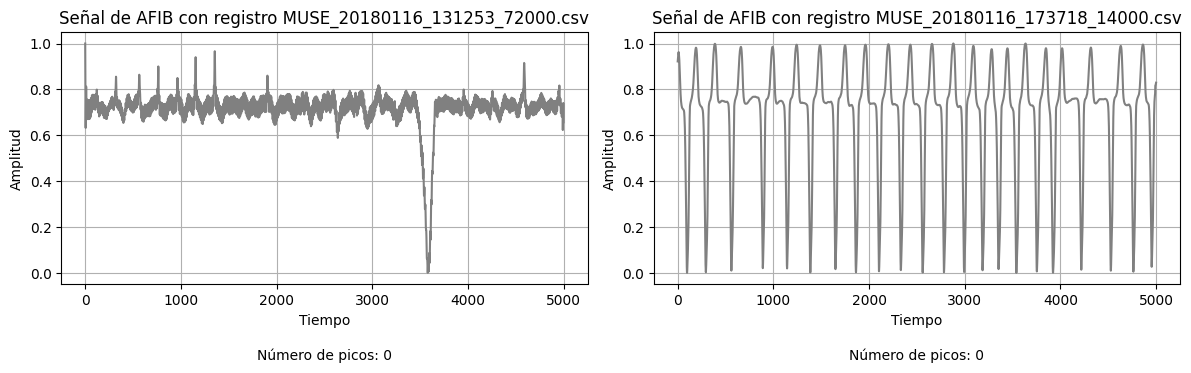

In [14]:
signal_AFIB_1 = df_AFIB[df_AFIB['Nombre Archivo'] == 'MUSE_20180116_131253_72000.csv']['II']
signal_compress_AFIB_1 = compression(signal_AFIB_1.iloc[0].values)
signals_peaks, rpeaks_AFIB_1= nk.ecg_peaks(signal_compress_AFIB_1, sampling_rate=fs, correct_artifacts=False)

signal_AFIB_2 = df_AFIB[df_AFIB['Nombre Archivo'] == 'MUSE_20180116_173718_14000.csv']['II']
signal_compress_AFIB_2= compression(signal_AFIB_2.iloc[0].values)
signals_peaks, rpeaks_AFIB_2= nk.ecg_peaks(signal_compress_AFIB_2, sampling_rate=fs, correct_artifacts=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].plot(signal_compress_AFIB_1, color="gray")
axes[0].set_title("Señal de AFIB con registro MUSE_20180116_131253_72000.csv")
axes[0].set_xlabel("Tiempo")
axes[0].set_ylabel("Amplitud")
axes[0].text(0.5, -0.3, f"Número de picos: {len(rpeaks_AFIB_1['ECG_R_Peaks'])}", ha='center', transform=axes[0].transAxes)
axes[0].grid()
axes[1].plot(signal_compress_AFIB_2,color="gray")
axes[1].set_title("Señal de AFIB con registro MUSE_20180116_173718_14000.csv")
axes[1].set_xlabel("Tiempo")
axes[1].set_ylabel("Amplitud")
axes[1].text(0.5, -0.3, f"Número de picos: {len(rpeaks_AFIB_2['ECG_R_Peaks'])}", ha='center', transform=axes[1].transAxes)
axes[1].grid()


plt.tight_layout()
plt.show()

Según lo anterior, puede verse que las dos señales que generarón el impedimento cuentan con una alta cantidad de ruido (para el caso de MUSE_20180116_131253_72000.csv) o una señal de ECG no muy clara (para el caso de MUSE_20180116_173718_14000.csv). **Según lo anterior, se decidió eliminar estos archivos de la base de datos con el fin de evitar los errores presentados**

Así mismo, al calcular la frecuencia cardíaca media se evidenció que dos archivos, uno de AFIB y otro de SB generaban valores NaN (MUSE_20180112_123809_34000 y MUSE_20180114_124930_50000.csv), por lo que también se detectaron y se eliminaron

In [15]:
fs = 500
for i, nombre in enumerate(df_SB['Nombre Archivo'].values):
  signal_compression_SB = compression(df_SB.loc[i, 'II'])
  signals_peaks, rpeaks= nk.ecg_peaks(signal_compression_SB, sampling_rate=fs, correct_artifacts=False)
  heart_rate = nk.ecg_rate(rpeaks, sampling_rate=fs, desired_length=None, interpolation_method='monotone_cubic', show=False)
  # Se extrae el promedio de la frecuencia cardiaca
  heart_rate_average= np.mean(heart_rate)
  if np.isnan(heart_rate_average):
    print(f"Valores NaN en {nombre} de SB")

/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Valores NaN en MUSE_20180112_123809_34000.csv de SB


In [16]:
fs = 500
for i, nombre in enumerate(df_AFIB['Nombre Archivo'].values):
  signal_compression_AFIB = compression(df_AFIB.loc[i, 'II'])
  signals_peaks, rpeaks_AFIB= nk.ecg_peaks(signal_compression_AFIB, sampling_rate=fs, correct_artifacts=False)
  heart_rate_AFIB = nk.ecg_rate(rpeaks_AFIB, sampling_rate=fs, desired_length=None, interpolation_method='monotone_cubic', show=False)
  # Se extrae el promedio de la frecuencia cardiaca
  heart_rate_average_AFIB= np.mean(heart_rate_AFIB)
  if np.isnan(heart_rate_average_AFIB):
    print(f"Valores NaN en {nombre} de AFIB")

/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Valores NaN en MUSE_20180114_124930_50000.csv de AFIB
Valores NaN en MUSE_20180116_131253_72000.csv de AFIB


/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Valores NaN en MUSE_20180116_173718_14000.csv de AFIB


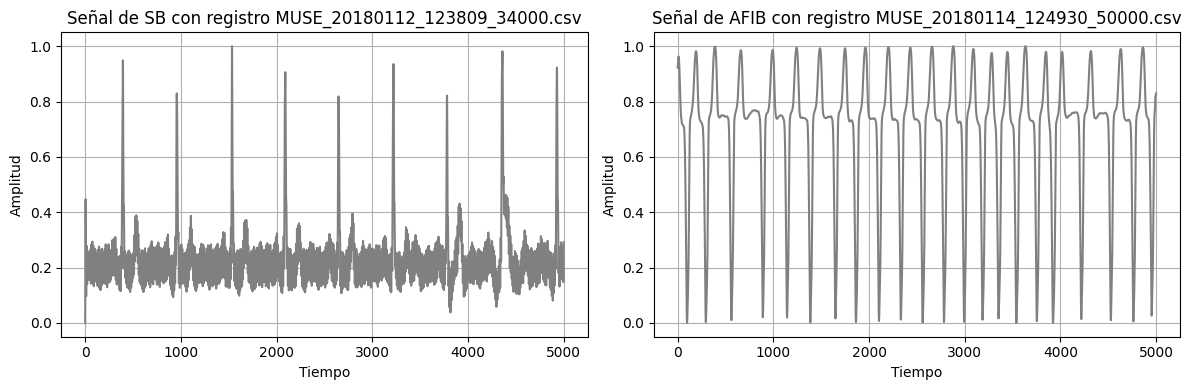

In [17]:
signal_SB_1 = df_SB[df_SB['Nombre Archivo'] == 'MUSE_20180112_123809_34000.csv']['II']
signal_compress_SB_1 = compression(signal_SB_1.iloc[0].values)

signal_SB_2 = df_AFIB[df_AFIB['Nombre Archivo'] == 'MUSE_20180114_124930_50000.csv']['II']
signal_compress_SB_2= compression(signal_AFIB_2.iloc[0].values)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].plot(signal_compress_SB_1, color="gray")
axes[0].set_title("Señal de SB con registro MUSE_20180112_123809_34000.csv")
axes[0].set_xlabel("Tiempo")
axes[0].set_ylabel("Amplitud")
axes[0].grid()
axes[1].plot(signal_compress_SB_2,color="gray")
axes[1].set_title("Señal de AFIB con registro MUSE_20180114_124930_50000.csv")
axes[1].set_xlabel("Tiempo")
axes[1].set_ylabel("Amplitud")
axes[1].grid()

plt.tight_layout()
plt.show()

De igual forma, los dos archivos que generaron valor NaN al calcular la frecuencia cardiaca media tienen ciertas características que no permiten reconocer señales de ECG o que las mismas tienen mucho ruido.

Finalmente, **se aplicaron las 6 características extraídas con NeuroKit2 a los dos grupos exceptuando los 4 archivos eliminados**

In [18]:
df_AFIB_new =  df_AFIB.copy()
df_AFIB_new = df_AFIB_new.drop(df_AFIB_new[df_AFIB_new['Nombre Archivo'] == 'MUSE_20180116_131253_72000.csv'].index)
df_AFIB_new = df_AFIB_new.drop(df_AFIB_new[df_AFIB_new['Nombre Archivo'] == 'MUSE_20180116_173718_14000.csv'].index)
df_AFIB_new = df_AFIB_new.drop(df_AFIB_new[df_AFIB_new['Nombre Archivo'] == 'MUSE_20180114_124930_50000.csv'].index)

fs = 500
list_data_AFIB = []
for index, row in df_AFIB_new.iterrows():
    nombre = row['Nombre Archivo']
    signal_compression_AFIB = compression(row['II'])
    MeanNN_AFIB, SDNN_AFIB, RMSSD_AFIB, pNN50_AFIB, shanen_AFIB, heart_rate_average_AFIB = extraccion_caracteristicas(row['II'], fs)
    data = {"Registro": nombre, "Estado": "AFIB", "MeanNN":MeanNN_AFIB, "SDNN":SDNN_AFIB,
            "RMSSD":RMSSD_AFIB, "pNN50":pNN50_AFIB, "Shanen":shanen_AFIB, "HrAv":heart_rate_average_AFIB}
    list_data_AFIB.append(data)

df_AFIB_data = pd.DataFrame(list_data_AFIB)

In [19]:
df_SB_new =  df_SB.copy()
df_SB_new = df_SB_new.drop(df_SB_new[df_SB_new['Nombre Archivo'] == 'MUSE_20180112_123809_34000.csv'].index)
fs = 500
list_data_SB = []
for index, row in df_SB_new.iterrows():
    nombre = row['Nombre Archivo']
    signal_compression = compression(row['II'])
    MeanNN_SB, SDNN_SB, RMSSD_SB, pNN50_SB, shanen_SB, heart_rate_average_SB = extraccion_caracteristicas(row['II'], fs=500)
    data = {"Registro": nombre, "Estado": "SB", "MeanNN":MeanNN_SB, "SDNN":SDNN_SB,
            "RMSSD":RMSSD_SB, "pNN50":pNN50_SB, "Shanen":shanen_SB, "HrAv":heart_rate_average_SB}
    list_data_SB.append(data)
df_SB_data = pd.DataFrame(list_data_SB)

#**6. DataFrame**



Inicialmente, se cargaron las fMP de cada grupo del proyecto 2 y también se eliminaron las 4 señales que no se utilizaron según lo visto anteriormente. Posteriormente se concatenaron los dataframes para obtener el dataframe final con las 7 características y la columna de Estado que posteriormente se binarizó.

In [20]:
data_ECG_Denoised = pd.read_csv('/content/drive/MyDrive/Bioseñales/data_ECG_Denoised.csv')
data_ECG_Denoised_new = data_ECG_Denoised.copy()
data_ECG_Denoised_new = data_ECG_Denoised_new.drop(data_ECG_Denoised_new[data_ECG_Denoised_new['Nombre Registro'] == 'MUSE_20180116_131253_72000.csv'].index)
data_ECG_Denoised_new = data_ECG_Denoised_new.drop(data_ECG_Denoised_new[data_ECG_Denoised_new['Nombre Registro'] == 'MUSE_20180116_173718_14000.csv'].index)
data_ECG_Denoised_new = data_ECG_Denoised_new.drop(data_ECG_Denoised_new[data_ECG_Denoised_new['Nombre Registro'] == 'MUSE_20180112_123809_34000.csv'].index)
data_ECG_Denoised_new = data_ECG_Denoised_new.rename(columns={'Nombre Registro': 'Registro'})
data_ECG_Denoised_new = data_ECG_Denoised_new[['Registro', 'fMP']]

In [21]:
df_features = pd.concat([df_AFIB_data,df_SB_data], ignore_index=True)
df_features = pd.merge(data_ECG_Denoised_new, df_features, on='Registro', how='inner')
nuevo_orden = ['Registro', 'Estado', 'fMP', 'MeanNN', 'SDNN', 'RMSSD', 'pNN50', 'Shanen', 'HrAv']
df_features = df_features.reindex(columns=nuevo_orden)
df_features

,Registro,Estado,fMP,MeanNN,SDNN,RMSSD,pNN50,Shanen,HrAv
0,MUSE_20180116_181214_58000.csv,SB,0.8,1213.142857,9.299258,10.033278,0.000000,0.188517,49.460498
1,MUSE_20180118_125051_70000.csv,SB,1.0,1009.111111,29.901691,41.012193,11.111111,0.676335,59.500505
2,MUSE_20180118_125036_12000.csv,SB,2.7,1113.250000,30.084405,36.831663,12.500000,0.162347,53.926936
3,MUSE_20180118_124944_51000.csv,SB,1.0,994.666667,67.742158,82.261777,22.222222,0.680739,60.579350
4,MUSE_20180118_124940_24000.csv,SB,2.9,1033.555556,7.195678,6.670832,0.000000,0.257133,58.054297
...,...,...,...,...,...,...,...,...,...
5660,MUSE_20180115_133556_54000.csv,AFIB,5.9,442.500000,141.351186,216.171959,50.000000,0.408890,145.242222
5661,MUSE_20180112_074903_07000.csv,AFIB,1.5,657.000000,84.193002,99.787466,35.714286,0.339480,92.509068
5662,MUSE_20180114_121533_70000.csv,AFIB,6.7,1137.500000,130.553766,153.492671,50.000000,0.310682,53.332637
5663,MUSE_20180114_073026_18000.csv,AFIB,2.4,490.736842,122.427685,138.513537,73.684211,0.360034,128.487751


#**7. Red Neuronal**


Para implementar la red neuronal, inicialmente es necesario aclara que se utilizó la librería Sklear, por lo que inicialmente se importa lo necesario para realizar el análisis.

In [22]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report,confusion_matrix

Posteriormente se hizo una copia del dataframe de las características, se eliminó la columna de registro y se binarizó la columna de estado donde:

**AFIB = 0**

**SB = 1**

Posteriormente se confirmó la no existencia de valores nulos

In [23]:
# Copia del dataframe original
df_only_features = df_features.copy()
# Eliminando la columna de registro
df_only_features = df_only_features.drop(columns=['Registro'])
# Binarizando la columna de estado
df_only_features['Estado'] = df_only_features['Estado'].map({'AFIB': 0, 'SB': 1})
# Verificando los tipos de datos en el dataframe para ver que no hay valores nulos.
df_only_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5665 entries, 0 to 5664
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Estado  5665 non-null   int64  
 1   fMP     5665 non-null   float64
 2   MeanNN  5665 non-null   float64
 3   SDNN    5665 non-null   float64
 4   RMSSD   5665 non-null   float64
 5   pNN50   5665 non-null   float64
 6   Shanen  5665 non-null   float64
 7   HrAv    5665 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 354.2 KB


Posteriormente **se definió a la etiqueta como la columna estado**. También **se normalizaron las características con Z-score** principalmente porque se evidenció que es un método muy utilizado en para Machine Learning [7].

Finalmente, se divieron los datos en grupos de entrenamiento y de prueba. En este caso **se definió una proporcial (90:10)**, utilizada en un estudio donde crearon redes neuronales convolucionales y algoritmos basados ​​en reglas para clasificar ECG de 12 derivaciones [8].


In [24]:
from sklearn.preprocessing import StandardScaler
# Etiqueta
etiqueta = ['Estado']
# Características
caracteristicas = list(set(list(df_only_features.columns))-set(etiqueta))
# Normalización de las características con z-score
scaler = StandardScaler()
df_only_features[caracteristicas] = scaler.fit_transform(df_only_features[caracteristicas])

# División de los datos para entrenamiento y prueba
X = df_only_features[caracteristicas].values # X = Datos de entrenamiento (tiene las características)
y = df_only_features[etiqueta].values # Y = Datos de entrenamiento (tiene la etiqueta)
# 10% de los datos para prueba y 90% para entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=40)
y_test = np.squeeze(y_test)
y_train = np.squeeze(y_train)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5098, 7)
(5098,)
(567, 7)
(567,)


Finalmente, se definifieron 3 arquitecturas con los siguientes parámetros:

1. **Arquitectura 1:** para esta arquitectura, los paramétros se definieron de la siguiente manera:

  - Número de capas ocultas: debido a que se desea hacer la comparación con 1, 2 y 3 capas, este se definió con una
  - Función de activación, solver definidas al azar
  - Learning_Rate: se definió como el menor, considerando que el entrenamiento tardara más tiempo a comparación de los demás
  - Nueronas por capas: según lo visto en clase, se aplicó la siguiente fórmula

Number_Neurons = (trading_data)/(factor*(input_neurons+output_neurons)) = 142

Donde:

       trading_data=5665 (cantidad de datos)
       Factor = 4 (se definió para tener un número de neuronas considerable)
       Input_neurons = número de características + 1 = 8
       Output_Neurons = 2 (AFIB y SB)

2. **Arquitectura 2**: esta arquitectura fué implementada en uun estudio comparativo realizado en la Universidad de los Andes donde se clasificaron señales de ECG con diferentes modelos, entre ellos, con MLPClassifier y probando para este diferente capas, neuronas por capas, funciones de activación y demás y la arquitectura con mejores resultados  fué la red con las siguientes característias [9]:

    -  2 Capas ocultas con 5 neuronas en cada capa
    - Función de activación Logistic
    - Solver sgd
    - Learning rate init de 0.01

3. **Arquitectura 3**: esta arquitectura también fué implementada en un estudio en donde se generó un sistema híbrido para la clasificación de arritmias cardíacas utilizando k vecinos más cercanos difusos y perceptrones multicapa combinados (MLPClassifier) y para este último se determinó que la mejor arquitectura tuvo las siguientes características [10]:

     - 3 Capas ocultas con 50, 100, 150 neuronas
     - Learning rate init de 0.3

Respecto a los demás paramétros, los mismos se definieron iguales que los de la arquitectura 1 a excepción que el learning_rate, el cual se decidió al azar.


In [25]:
# Arquitectura 1: Eligiendo el número de capas, la función de activación, el solver y el learning rate definidos al azar
mlp_1 = MLPClassifier(hidden_layer_sizes=(142), activation='relu', solver='adam', max_iter=1000, learning_rate_init=0.001)
mlp_1.fit(X_train,y_train)
predict_train_1 = mlp_1.predict(X_train)
predict_test_1 = mlp_1.predict(X_test)
# Arquitectura 2: Extraída de [9]
mlp_2 = MLPClassifier(hidden_layer_sizes=(5,5), activation='logistic', solver='sgd', max_iter=1000, learning_rate_init=0.01)
mlp_2.fit(X_train,y_train)
predict_train_2 = mlp_2.predict(X_train)
predict_test_2 = mlp_2.predict(X_test)
# Arquitectura 3: Extraída de [10]
mlp_3 = MLPClassifier(hidden_layer_sizes=(50, 100, 150), activation='relu', solver='adam', max_iter=1000, learning_rate_init=0.3)
mlp_3.fit(X_train,y_train)
predict_train_3 = mlp_3.predict(X_train)
predict_test_3 = mlp_3.predict(X_test)

###**Matrices de Confusión**

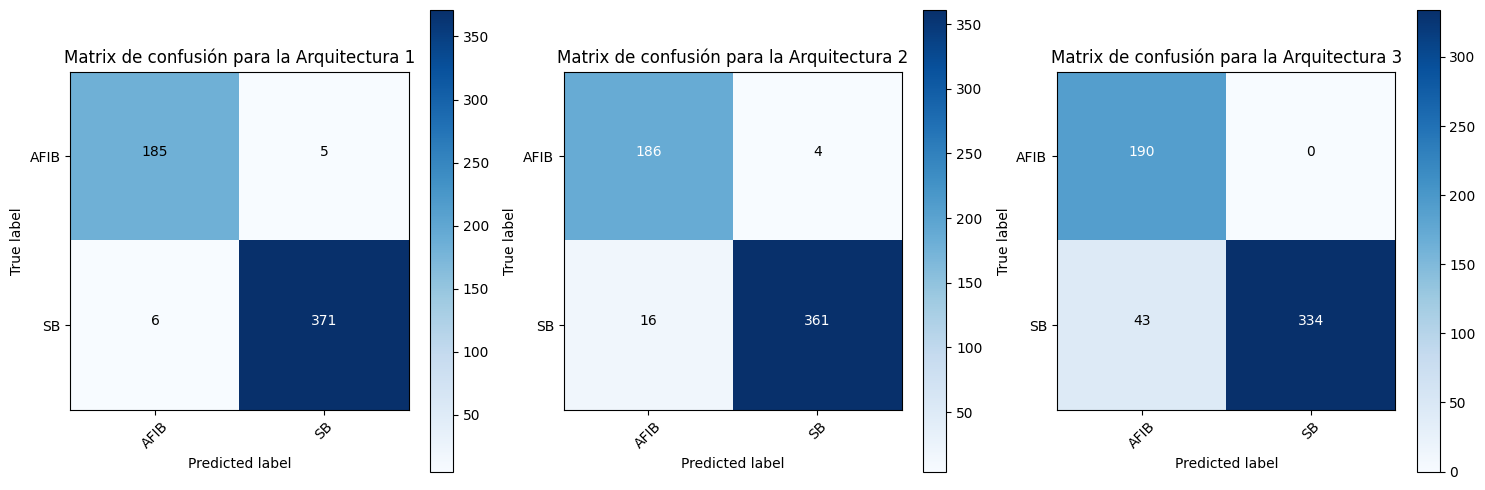

In [26]:
import itertools
from sklearn.metrics import confusion_matrix

cm_1 = confusion_matrix(y_test, predict_test_1)
cm_2 = confusion_matrix(y_test, predict_test_2)
cm_3 = confusion_matrix(y_test, predict_test_3)

labels = ['AFIB', 'SB']

def plot_confusion_matrix(cm, title, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plot_confusion_matrix(cm_1, "Matrix de confusión para la Arquitectura 1")

plt.subplot(1, 3, 2)
plot_confusion_matrix(cm_2, "Matrix de confusión para la Arquitectura 2")

plt.subplot(1, 3, 3)
plot_confusion_matrix(cm_3, "Matrix de confusión para la Arquitectura 3")

plt.show()

Según lo evidenciado en las matrices de confusión de cada arquitectura **se puede determinar que el menor número de clasificados con AFIB que tenían en realidad SB (falsos positivos) se obtuvo con la arquitectura 1**. Sin embargo, **para la aquitectura 3 solo existió un falso negativo (solo un clasificado que se predijo con SB cuando en realidad tenía AFIB) pero una gran cantidad de falsos positivos.**

Por su parte, para la matriz de confusión de la arquitectura 2, se puede detemrinar que se encuentra en el intermedio, dado que si tiene mayores falsos positivos que para la arquitectura 1 pero menos que para la arquitectura 3 y, respecto a los falsos negativos, tiene más que para la arquitectura 1.

**Lo anterior podría indicar de forma inicial que el primer modelo cuenta con el mejor rendimiento, dado que en general, tuvo los menores falsos positivos y falsos negativos**

Ahora, se imprimirá el reporte de entrenamiento y de prueba de cada modelo creado para cada arquitectura con el fin de revisar las métricas de evaluación. Es importante aclarar que se imprime tanto el reporte de los datos cuando se entrenaron como cuando se probaron con el fin de evidenciar un posible sobreajuste (en caso de que el rendimiento del modelo sea mejor en entrenamiento que en prueba).

### **Métricas de Evaluación**

In [27]:
target_names = ['AFIB', 'SB']
print("-------------Reporte datos entrenamiento Arquitectura 1 -------------------")
print(classification_report(y_train,predict_train_1,target_names=target_names))
print("-------------Reporte datos prueba Arquitectura 1 -------------------")
print(classification_report(y_test,predict_test_1,target_names=target_names))

-------------Reporte datos entrenamiento Arquitectura 1 -------------------
              precision    recall  f1-score   support

        AFIB       0.98      0.99      0.98      1587
          SB       0.99      0.99      0.99      3511

    accuracy                           0.99      5098
   macro avg       0.99      0.99      0.99      5098
weighted avg       0.99      0.99      0.99      5098

-------------Reporte datos prueba Arquitectura 1 -------------------
              precision    recall  f1-score   support

        AFIB       0.97      0.97      0.97       190
          SB       0.99      0.98      0.99       377

    accuracy                           0.98       567
   macro avg       0.98      0.98      0.98       567
weighted avg       0.98      0.98      0.98       567



Los resultados anteriores respresentan un **informe con las métricas de evaluación para el modelo creado con la arquitectura 1**

De lo anterior se puede concluir que el **Acuracy del modelo fué del 99% en entrenamiento y del 98% en prueba**. Según lo anterior, el rendimiento del modelo disminuyó muy poco al probarlo.

Ahora, debido a que los datos para cada grupo no están balanceados, la métrica del Acuracy puede que no sea muy confiable. Así mismo, dado que el F1-Score integra tanto el Recall como la presición, nos centraremos en esta métrica.

Según lo anterior, **el F1-Score para AFIB y SB fueron del 98% y 99% respectivamente en entrenamiento y en validación, disminuyó al 97% para el caso de AFIB**.

**Se puede decir que el modelo 1 clasifica correctamente a los dos grupos pero en mayor medida a los pacientes con SB, posiblemente al desbalance de los datos**

In [28]:
target_names = ['AFIB', 'SB']
print("-------------Reporte datos entrenamiento Arquitectura 2 -------------------")
print(classification_report(y_train,predict_train_2,target_names=target_names))
print("-------------Reporte datos prueba Arquitectura 2 -------------------")
print(classification_report(y_test,predict_test_2,target_names=target_names))

-------------Reporte datos entrenamiento Arquitectura 2 -------------------
              precision    recall  f1-score   support

        AFIB       0.94      0.97      0.95      1587
          SB       0.99      0.97      0.98      3511

    accuracy                           0.97      5098
   macro avg       0.96      0.97      0.97      5098
weighted avg       0.97      0.97      0.97      5098

-------------Reporte datos prueba Arquitectura 2 -------------------
              precision    recall  f1-score   support

        AFIB       0.92      0.98      0.95       190
          SB       0.99      0.96      0.97       377

    accuracy                           0.96       567
   macro avg       0.95      0.97      0.96       567
weighted avg       0.97      0.96      0.96       567



**Para el modelo 2, utilizando la arquitectura 2, se evidencia que el F1-Score fué mayor para SB (97%) que para AFIB (95%) en menor medida que el modelo anterior**.

Por otro lado, **el modelo tuvo cambios mínimos entre las métricas de prueba y entrenamiento y el F1-Sore disminuyó para AFIB con los datos de prueba.**

In [29]:
target_names = ['AFIB', 'SB']
print("-------------Reporte datos entrenamiento Arquitectura 3 -------------------")
print(classification_report(y_train,predict_train_3,target_names=target_names))
print("-------------Reporte datos prueba Arquitectura 3 -------------------")
print(classification_report(y_test,predict_test_3,target_names=target_names))

-------------Reporte datos entrenamiento Arquitectura 3 -------------------
              precision    recall  f1-score   support

        AFIB       0.81      1.00      0.89      1587
          SB       1.00      0.89      0.94      3511

    accuracy                           0.93      5098
   macro avg       0.90      0.95      0.92      5098
weighted avg       0.94      0.93      0.93      5098

-------------Reporte datos prueba Arquitectura 3 -------------------
              precision    recall  f1-score   support

        AFIB       0.82      1.00      0.90       190
          SB       1.00      0.89      0.94       377

    accuracy                           0.92       567
   macro avg       0.91      0.94      0.92       567
weighted avg       0.94      0.92      0.93       567



Finalmente, **para el modelo 3 (arquitectura 3)** se evidencia una disminución en el Acuracy respecto a los demás modelos.

Así mismo, **obtuvo el menor F1-Score para AFIB y para SB, tuvo el
mejor para el caso de los datos de prueba.**

### **Curvas de pérdida**

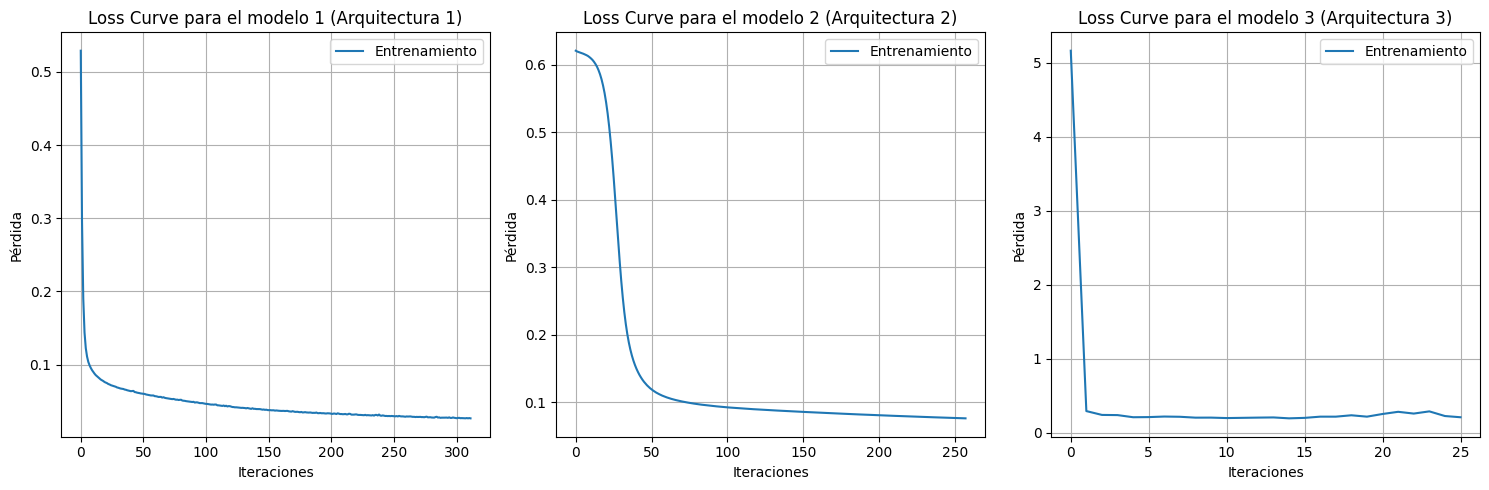

In [30]:
from sklearn.metrics import log_loss
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes[0].plot(mlp_1.loss_curve_, label="Entrenamiento")
axes[0].set_title("Loss Curve para el modelo 1 (Arquitectura 1)")
axes[0].set_xlabel("Iteraciones")
axes[0].set_ylabel("Pérdida")
axes[0].legend()
axes[0].grid()

axes[1].plot(mlp_2.loss_curve_, label="Entrenamiento")
axes[1].set_title("Loss Curve para el modelo 2 (Arquitectura 2)")
axes[1].set_xlabel("Iteraciones")
axes[1].set_ylabel("Pérdida")
axes[1].legend()
axes[1].grid()

axes[2].plot(mlp_3.loss_curve_,label="Entrenamiento")
axes[2].set_title("Loss Curve para el modelo 3 (Arquitectura 3)")
axes[2].set_xlabel("Iteraciones")
axes[2].set_ylabel("Pérdida")
axes[2].legend()
axes[2].grid()

plt.tight_layout()
plt.show()

Al analizar las curvas de pérdida, cada arquitectura mostró comportamientos únicos. La primera, con su única capa oculta, evidenció un aprendizaje cauteloso pero potencialmente insuficiente, reflejado en un descenso gradual de la pérdida durante el entrenamiento mientras mantenía una pérdida de prueba constantemente baja.
La segunda arquitectura, aunque más modesta en su diseño con dos capas ocultas y cinco neuronas por capa, logró un equilibrio interesante: un descenso moderado en la pérdida de entrenamiento acompañado de una estabilidad consistente en las pruebas. Si bien esto sugiere un ajuste adecuado, podría estar simplificando demasiado el problema.
Por su parte, la tercera arquitectura resultó ser la más intrigante. Su estructura más compleja, con tres capas ocultas de tamaño creciente, produjo una caída dramática en la pérdida de entrenamiento.

Por otro lado, no se mostraron las curvas de pérdida para el caso del proceso de validación debido a complicaciones al momento de implementar diferentes códigs, por lo que el análisis hecho anteriormente no determina una comparación fiel entre el rendimiento de los modelos en entrenamiento y validación.

#**8. Consultas: SVM y K means**


En el documento de consultas se explicó un poco cada uno de estos algoritmos con ejemplos de cada uno. Sin embargo, a continuación se muestra la implementación de cada uno con los datos del proyecto.

[Consultas Proyecto 4](https://docs.google.com/document/d/12nTGzbK5JAjV9nh_iTNFU-E_y7MoYrLhJz70U5tDvMk/edit?usp=sharing)

## **Implementación SVM**

Este algoritmo también pertenece al aprendizaje supervisado y funciona mejor, según lo visto en clase, con un gran número de características pero con pocas observaciones (lo cual no es nuestro caso).

In [31]:
# Importando la librería
from sklearn import svm
# Creando el modelo, con el parámetro gamma automático
clf = svm.NuSVC(gamma='auto')
# Entrenando el modelo
clf.fit(X_train,y_train)
# Valores de entrenamiento
predict_train_SVM = clf.predict(X_train)
# Valores de prueba
predict_test_SVM= clf.predict(X_test)

#### **Matriz de Confusión para SVM**

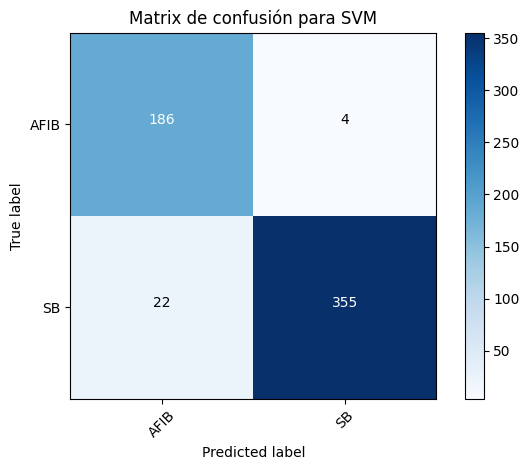

In [32]:
plot_confusion_matrix(confusion_matrix(y_test, predict_test_SVM), "Matrix de confusión para SVM")

La matríz de confusión anterior nos indica que para este tipo de modelo de clasificación existe un mayor valor de Falsos Positivos, lo que indica que el modelo puede clasificar mal a pacientes con AFIB cuando en realidad tienen SB. Por otro lado, la cantidad de falsos negativos es baja.

#### **Métricas de evaluación SVM**

In [33]:
target_names = ['AFIB', 'SB']
print("-------------Reporte datos entrenamiento SVM -------------------")
print(classification_report(y_train,predict_train_SVM,target_names=target_names))
print("-------------Reporte datos prueba SVM -------------------")
print(classification_report(y_test,predict_test_SVM,target_names=target_names))

-------------Reporte datos entrenamiento SVM -------------------
              precision    recall  f1-score   support

        AFIB       0.89      0.97      0.93      1587
          SB       0.98      0.95      0.97      3511

    accuracy                           0.95      5098
   macro avg       0.94      0.96      0.95      5098
weighted avg       0.96      0.95      0.95      5098

-------------Reporte datos prueba SVM -------------------
              precision    recall  f1-score   support

        AFIB       0.89      0.98      0.93       190
          SB       0.99      0.94      0.96       377

    accuracy                           0.95       567
   macro avg       0.94      0.96      0.95       567
weighted avg       0.96      0.95      0.95       567



Según lo anterior, puede decirse que el modelo tiene una precisión general del 95% (accuracy). Respecto al F1-Score, el mismo es menor para la variable de AFIB que para la variable de SB en los datos de prueba.

También la precisión para los datos de prueba es menor para AFIB que para SB, lo que indica que existe un menor porcentaje de pacientes con AFIB clasificados correctamente.

## **Implementación K-Means**

Este es de aprendizaje no supervisado, por lo que no es necesario etiquetar los datos. Según lo anterior, se busca que los datos de este proyecto con las características elegidas puedan crear grupos naturales, para ello, se realizará un proceso de clusterización.

La agrupación por Clustering es muy sensible a los datos y se afecta si no todos los datos están en la misma escala, sin embargo, al implementar los datos escalados y no, no se evidenciaron diferencias.

In [34]:
# Características para el clustering obtenidas del dataframe df_only_features
data = df_only_features[['fMP', 'MeanNN', 'SDNN', 'RMSSD', 'pNN50', 'Shanen', 'HrAv']].values
# Escalando los datos
from sklearn.preprocessing import scale
scaled = scale(data)

Para conocer el número de clausters, los cuales nos permitirán que el modelo reconozco la agrupación propia de los datos, se utiliza el método del codo. La implementación del mismo se muestra a continuación.


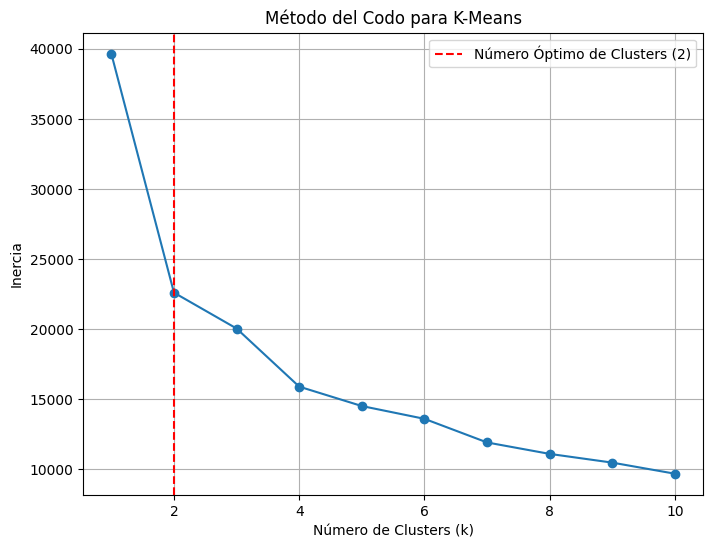

In [35]:
from sklearn.cluster import KMeans
inertia = []
# Probando con 10 valores de K (clauster)
for k in range(1, 11):
    # Creando el modelo
    kmeans = KMeans(n_clusters=k, random_state=0)
    # Ajustando los datos
    kmeans.fit(scaled)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para K-Means')
optimal_k = 2
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Número Óptimo de Clusters ({optimal_k})')

plt.grid()
plt.legend()
plt.show()

Según lo anterior, el valor para K (clauster) se define con la mayor angulación de la gráfica  y los resultados obtenidos determinan lo que se esperaba al tener solo dos grupos esperados en el modelo: AFIB y SB

In [36]:
# Inicializamos el algoritmo de K-Means con k=2
kmeans = KMeans(n_clusters=2, random_state=0)
# Aplicamos el algoritmo a los datos
kmeans = kmeans.fit(scaled)
# Obtener las etiquetas de clúster para cada punto de datos
labels = kmeans.labels_
# Centroides
centroides = kmeans.cluster_centers_

Finalmente se analiza gráficamente como se organizaron los datos

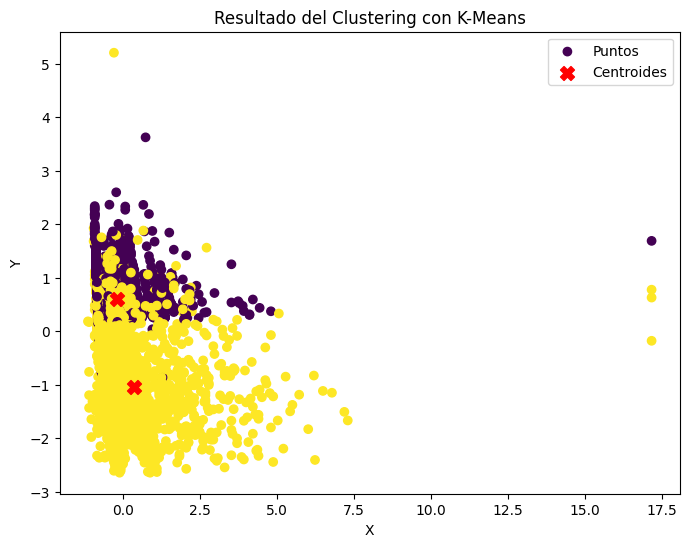

In [37]:
# Crear el gráfico
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', label='Puntos')
plt.scatter(centroides[:, 0], centroides[:, 1], c='red', marker='X', s=100, label='Centroides')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Resultado del Clustering con K-Means')
plt.show()

El gráfico anterior muestra los resultados obtenidos. Como se muestra, en los colores amarillo y azul se muestran dos grupos definidos con algunos valores superpuestos entre si, lo que podría indica que existen datos que no pudieron separarse correctamente disminuyendo la capacidad de diferenciación del modelo. Así mismo, existen valores muy alejados de los grupos principales, lo que también indica una incapacidad del modelo para clasificar algunos datos.


### **Métrica de evaluación**

Para el aprendizaje no supervisado existen métricas diferentes a las utilizadas en el aprendizaje supervisado como el SVM y las redes neuronales.

En este caso solo se evaluará una:

**Índice de Davies-Bouldin**: Cuanto más ajustado sea el clauster y más separados estén los clausters, más bajo será este valor, por lo que los valores más próximos a 0 son mejores. Los clústeres que estén más separados y menos dispersos generarán una mejor puntuación [11].



In [38]:
# Importando la librería
from sklearn.metrics import davies_bouldin_score
# Índice de Davies-Bouldin
davies_bouldin = davies_bouldin_score(data, kmeans.labels_)
print("Davies-Bouldin Index:", davies_bouldin)

Davies-Bouldin Index: 1.0107410165752513


El valor obtenido anteriomente indica un bajo ajuste de los clausters y una dispersión de los mismos. Según lo anterior, el modelo implementado no cuenta con un buen rendimiento según estos resultados aunque se hace necesario revisar otras métricas de evaluación.

# **9. Informe de los resultados obtenidos**

## **Equipos comerciales consultados:**
[Consultas Proyecto 4](https://docs.google.com/document/d/12nTGzbK5JAjV9nh_iTNFU-E_y7MoYrLhJz70U5tDvMk/edit?usp=sharing)



## **Extracción de características**

La mayoría de las características elegidas se relacionaron principalmente con estudios revisados para la detección de fibrilación auricular (AFIB). También, se trató que el análisis se hiciera de manera temporal (con las características asociadas a la variación de la frecuencia cardíaca) y en el dominio de la frecuencia (con la fMP). También se adicionó a la entropia de shannon debido a los resultados obtenidos en el código implementado para el tutorial.

Por otro lado, según los resultados obtenidos en los modelos, los cuales fueron muy buenos en general, se podría decir que la elección de las características fué buena pero no tan centrada a detectar AFIB, posiblemente por el desbalanceo de los datos.

## **Arquitecturas implementadas:**

Respecto a las arquitecturas, es necesario indicar que **se le dió mayor importancia a los resultados obtenidos en los 3 modelos para los pacientes con AFIB (variable positiva).** Lo anterior principalmente debido a que la fibrilación auricular, según la revista Colombiana del Cardiología, es una arritmia asociada al incremento de la morbilidad y hospitalizaciones. Así mismo, se asocia con un alto riesgo de accidentes cerebrovasculares y muerte cardíaca súbita [12].

De acuerdo a lo ya mencionado, para los modelos 1 y 2 se evidencia que existe una mayor capacidad de cada modelo para clasificar pacientes con SB correctamente, esto posiblemente a que existen un mayor número de datos de SB que de AFIB. Sin embargo, se encontraron valores de F1-Score más cercanos al 100% para el modelo 1, el cual, también es mucho más sencillo dado que solo cuenta con una capa oculta y el número de neuronas en la misma se calculcó con la fórmula mencionada en clase.

Si bien el modelo 2 no tuvo un mal rendimiento debido a sus valores de F1-Score, tuvo un mayor número de falsos positivos y falsos negativos que el modelo 1. Respecto a su arquitectura, la misma fué extraída de un estudio comparativo para la detección de enfermedades cardíacas de donde se estudiaron 56 características, de las cuales se compartían algunas de las implementadas como RMSSD y MeanNN extraídas de igual forma con NeuroKit2, adicionalmente el estudio contó con más de 8mil datos. Si bien las condiciones no son las mismas que las del presente proyecto, determinamos utilizar la arquitectura propuesta con el fin de reconocer como se comportaría con nuestros datos y en general, el rendimiento fué también muy bueno.

Por otro lado, el modelo 3 fué el que menor rendimiento tuvo y su arquitectura también se extrajo de un artículo donde implementaron una arquitectura híbrida integrada por k vecinos más cercanos difusos y perceptrones multicapa combinados y para el análisis de este último, se determinó a la arquitectura utilizada como la implementada para crear esta arquitectura híbrida. Dentro de las especificaciones del estudio, en el mismo se tenían 150 características y 500 muestras. También, junto con la arquitectura del modelo 2, no cuenta con las mismas características del presente proyecto pero también se quizo implementar debido a sus especificaciones. Finalmente, se destaca que este  modelo tuvo el mejor rendimiento para clasificar SB.

## **Implementación SVM:**

La implementación del algoritmo SVM (Support Vector Machines), específicamente utilizando el modelo NuSVC con el parámetro gamma='auto', permitió realizar una clasificación de dos clases: AFIB y SB. Aunque SVM es particularmente eficiente en contextos con un alto número de características y pocas observaciones, se decidió aplicarlo a este caso con pocas características y observaciones desbalanceadas, obteniendo resultados satisfactorios.

La matriz de confusión obtenida para los datos de prueba revela una tendencia del modelo a generar un mayor número de falsos positivos. Esto implica que el modelo clasifica erróneamente a pacientes como AFIB cuando en realidad tienen SB. Por el contrario, la cantidad de falsos negativos es reducida, lo que significa que el modelo tiene un buen desempeño identificando correctamente a los pacientes con AFIB. Este patrón en la matriz sugiere que el modelo podría ser más conservador al detectar la clase SB, pero más propenso a sobrediagnosticar la clase AFIB, lo que podría requerir un ajuste del balanceo de datos para equilibrar la sensibilidad y especificidad según el objetivo clínico.

En cuanto a las métricas de evaluación, tanto en los datos de entrenamiento como en los de prueba, el modelo logró un accuracy global del 95%. Este valor refleja un buen desempeño general en la clasificación. Sin embargo, al analizar las métricas por clase, se observa que el modelo tiene un desempeño ligeramente inferior para la clase AFIB en comparación con SB. Para los datos de prueba, la precisión de AFIB fue del 89%, mientras que para SB fue del 99%. Esto indica que el modelo tiene mayor probabilidad de clasificar correctamente a los pacientes con SB que a los pacientes con AFIB.

El F1-Score, que es una métrica balanceada entre precisión y recall, también es menor para AFIB (0.93) en comparación con SB (0.96) en los datos de prueba. Esto confirma que, aunque el modelo muestra un buen equilibrio entre las métricas, la capacidad de clasificar correctamente a los pacientes con AFIB es menor, lo que puede ser crítico en aplicaciones donde esta condición tiene mayor relevancia clínica. En términos de recall, el modelo tuvo un desempeño destacable para AFIB (0.98), lo que sugiere que la mayoría de los pacientes con esta condición son detectados. Sin embargo, esto viene acompañado de un ligero aumento en falsos positivos, como se mencionó anteriormente.

Finalmente, al comparar las métricas de los datos de entrenamiento y prueba, se observa una consistencia en los resultados, lo que sugiere que el modelo no está sobreajustado a los datos de entrenamiento y generaliza bien. No obstante, la menor precisión para la clase AFIB en los datos de prueba podría estar relacionada con una distribución desequilibrada de las clases en el conjunto de datos o con características que no separan claramente ambas condiciones. Esto abre la posibilidad de explorar técnicas adicionales, como ajustes en los pesos de las clases, modificaciones en el kernel del SVM o el uso de algoritmos complementarios, para mejorar el desempeño específicamente en la detección de AFIB. En general, el modelo demuestra ser una herramienta confiable, pero con áreas de mejora para optimizar la precisión en condiciones críticas como AFIB.

## **Implementación K-means:**


La implementación del algoritmo K-Means permitió realizar un proceso de clusterización con los datos seleccionados, aprovechando características como fMP, MeanNN, SDNN, RMSSD, pNN50, Shanen y HrAv. Este método, al ser de aprendizaje no supervisado, no requiere etiquetas previas, lo que lo hace ideal para explorar la agrupación natural de los datos sin una intervención inicial. Para garantizar que las características estuvieran en la misma escala y mejorar el desempeño del algoritmo, se realizó una normalización previa de los datos, aunque no se evidenciaron diferencias significativas al comparar resultados con y sin escalado, probablemente debido a una distribución inicial uniforme en las características.

Para determinar el número óptimo de clústeres, se utilizó el método del codo. Este método evalúa la inercia (suma de distancias cuadradas de los puntos al centroide más cercano) a medida que se incrementa el número de clústeres. La gráfica obtenida mostró una clara inflexión en k=2, lo que se alinea con las expectativas, ya que las dos clases esperadas en el modelo corresponden a AFIB y SB. Esta elección asegura que el algoritmo no sobredimensione el número de agrupaciones, maximizando así la simplicidad del modelo y la capacidad de interpretación.

El análisis gráfico posterior evidenció la formación de dos grupos principales, representados por colores distintos (amarillo y azul). Los centroides, marcados en rojo, se posicionaron en las zonas de mayor densidad de datos dentro de cada clúster, lo que confirma que el algoritmo logró capturar las tendencias principales del conjunto de datos. Sin embargo, también se observaron ciertas limitaciones. Algunos puntos de datos quedaron superpuestos entre los dos clústeres, lo que sugiere que el modelo no logró una separación perfecta entre las clases AFIB y SB. Este solapamiento podría estar relacionado con características no suficientemente discriminativas o con una naturaleza intrínsecamente mixta de algunos datos.

Adicionalmente, se detectaron valores alejados de los grupos principales, conocidos como outliers. Estos puntos indican que el modelo tuvo dificultades para clasificarlos adecuadamente, lo cual puede deberse a una insuficiencia en la captura de las variaciones presentes en los datos. La presencia de outliers no solo reduce la capacidad de diferenciación del modelo, sino que también podría impactar en la posición de los centroides, desviándolos de las zonas óptimas de agrupación.

En general, la implementación de K-Means ofreció una visión preliminar de la estructura de los datos, identificando dos agrupaciones principales que se alinean con las clases esperadas. Sin embargo, la superposición entre los grupos y la presencia de outliers resaltan la necesidad de explorar técnicas complementarias, como el uso de algoritmos de clustering más robustos (por ejemplo, DBSCAN o Gaussian Mixture Models) o un análisis más exhaustivo de las características empleadas para el clustering. Esto podría optimizar la capacidad del modelo para diferenciar entre las clases y reducir la cantidad de datos mal clasificados.

# **Conclusiones**

- Se puede concluir que el modelo 1 implementado tuvo el mejor rendimiento para la clasificación de pacientes con AFIB a pesar de que en general, todos los modelos clasificaron mejor a pacientes con SB. Por otro lado, a pesar de que las características de los artículos citados para implementar las arquitecturas de los modelos 2 y 3 no fueron las mismas del presente proyecto (en términos de cantidad de datos, características y fines de clasificación), los rendimientos de los dos modelos fueron buenos, más para el caso del modelo 3 que tuvo el mejor rendimiento para clasificar SB

- También puede concluirse que el desbalanceo de los datos influyó considerablemente en que para los 3 modelos, se clasificara mejor para la bradicardia sinusal (SB).

- Los algoritmos de SVM y K-means implementados demostraron la viabilidad de la clasificación automática basada en las características extraídas de las señales (fMP, MeanNN, SDNN, RMSSD, pNN50, Shanen y HrAv). SVM alcanzó un accuracy global del 95% con un recall destacable en AFIB (0.89), mientras que K-Means logró identificar naturalmente dos grupos diferenciados. Sin embargo, las limitaciones observadas en ambos modelos (falsos positivos en SVM y superposición de clústeres en K-Means) sugieren que las características actuales, aunque funcionales, requieren refinamiento para mejorar la separabilidad entre AFIB y SB, especialmente en casos límite y outliers.


# **Trabajo Futuro**

Debido al desbalanceo de lo datos, podría funcionar tomar menos datos del grupo más numeroso (SB) con el fin de banalancear los datos y permitir resultados menos sesgados. Así mismo, podría implementarse las curvas de pérdida en comparación con entrenamiento y prueba con el fin de revisar un posible sobreajuste en los datos.

# **Referencias**

[1] Zheng, Jianwei (2019). ChapmanECG. figshare. Collection. https://doi.org/10.6084/m9.figshare.c.4560497.v1

[2] Makowski, D., Pham, T., Lau, Z. J., Brammer, J. C., Lespinasse, F., Pham, H., Schölzel, C., & Chen, S. A. (2021). NeuroKit2: A Python toolbox for neurophysiological signal processing. Behavior Research Methods, 53(4), 1689-1696. https://doi.org/10.3758/s13428-020-01516-y.

[3] A. E. De Koning et al., "Average heart rate, atrial fibrillation and R-on-T ventricular ectopy in 24h Holter recordings predict all-cause mortality in healthy middle-aged men," Computers in Cardiology, 2003, Thessaloniki, Greece, 2003, pp. 93-96, doi: 10.1109/CIC.2003.1291098.

[4] Garrido-Lestache, M. E., Rodríguez-Monte, L., & Bullón, M. C. (2011). Alteraciones del ritmo cardíaco: bradiarritmias y taquiarritmias. Anales de Pediatría Continuada, 9(6), 347-357. https://doi.org/10.1016/s1696-2818(11)70051-8

[5] F. T. Johura, S. M. R. Islam, M. Maniruzzaman and M. Hasan, "ECG signal for artrial fibrillation detection," 2017 International Conference on Electrical, Computer and Communication Engineering (ECCE), Cox's Bazar, Bangladesh, 2017, pp. 928-934, doi: 10.1109/ECACE.2017.7913036.

[6] Zhou, X., Ding, H., Ung, B. et al. Detección automática en línea de fibrilación auricular basada en dinámica simbólica y entropía de Shannon. BioMed Eng OnLine 13 , 18 (2014). https://doi.org/10.1186/1475-925X-13-18

[7] A. Casero, “Métodos de normalización en Python: ¿cuáles existen?,” KeepCoding Bootcamps, Sep. 29, 2024. https://keepcoding.io/blog/metodos-de-normalizacion-en-python/

[8] B. -J. Singstad and C. Tronstad, "Convolutional Neural Network and Rule-Based Algorithms for Classifying 12-lead ECGs," 2020 Computing in Cardiology, Rimini, Italy, 2020, pp. 1-4, doi: 10.22489/CinC.2020.227.

[9] M. R. G. Esteban, “Clasificación de señales ECG para la detección de enfermedades cardíacas : un estudio comparativo,” Repositorio Institucional Séneca, 2020. http://hdl.handle.net/1992/51547

[10] E. Ramírez, O. Castillo and J. Soria, "Hybrid system for cardiac arrhythmia classification with fuzzy k-nearest neighbors and Multi Layer Perceptrons combined by a fuzzy inference system," The 2010 International Joint Conference on Neural Networks (IJCNN), Barcelona, Spain, 2010, pp. 1-6, doi: 10.1109/IJCNN.2010.5597548.

[11] “Algoritmos de Clustering.” https://www.cs.us.es/~fsancho/Blog/posts/Clustering/#m%C3%A9tricas/validaci%C3%B3ninterna

[12] J.-A. Ramírez-Penuela y A. F. Buitrago, «Predictores de mortalidad en pacientes hospitalizados con fibrilación auricular en un hospital universitario», Revista Colombiana de Cardiología, vol. 26, n.o 6, pp. 322-327, doi: 10.1016/j.rccar.2018.10.012.